In [26]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import math
from collections import Counter

create dict of run:pval for p and p:stat for c and l

cvals, lvals = [], []
for p in runs[run]:
    for c in cdict:
        cval = np.mean(cdict[p])
        cvals.append(cval)
    for l in ldict:
        lval = np.mean(ldict[p])
        lvals.append(lval)

getting every p-value from the run:value dict then, for each of those values, getting a list of its values in the p:stat dict

must create a new dict of p:avgstat

must first create dicts runs, ldict, and cdict
-- do this in loop
for each run of inner loop, append dicts

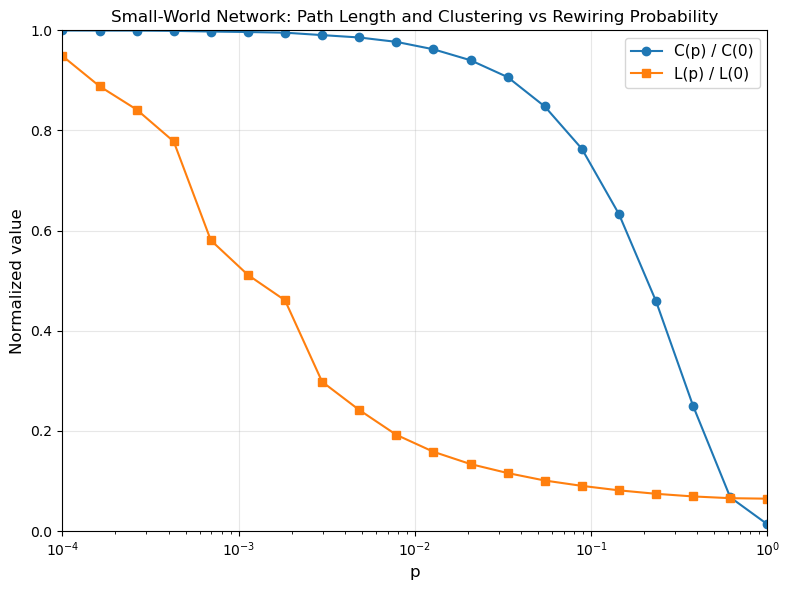

In [12]:
# 1

# getting L(0) and C(0)
normalizer = nx.watts_strogatz_graph(1000, 10, 0)
C0 = nx.average_clustering(normalizer)
L0 = nx.average_shortest_path_length(normalizer)

# storage for trials
pspace = np.logspace(-4, 0, 20)
cdict = {p: [] for p in pspace}
ldict = {p: [] for p in pspace}

for i in range(1, 21): # all trials to average over
    for p in pspace: # getting correct p values
        G = nx.watts_strogatz_graph(1000, 10, p)
        cdict[p].append(nx.average_clustering(G) / C0)
        ldict[p].append(nx.average_shortest_path_length(G) / L0)

# list of averaged values
cvals = [np.mean(cdict[p]) for p in pspace]
lvals = [np.mean(ldict[p]) for p in pspace]
# list of p values
pvals = list(pspace)

# plotting
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(pvals, cvals, 'o-', label='C(p) / C(0)', markersize=6)
ax.plot(pvals, lvals, 's-', label='L(p) / L(0)', markersize=6)

ax.set_xscale('log')
ax.set_xlabel('p', fontsize=12)
ax.set_ylabel('Normalized value', fontsize=12)
ax.set_xlim(1e-4, 1)
ax.set_ylim(0, 1)
ax.legend(fontsize=11)
ax.set_title('Small-World Network: Path Length and Clustering vs Rewiring Probability')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(r'.\imgs\watts_strogatz_figure2.png', dpi=150)
plt.show()

<Figure size 1000x600 with 0 Axes>

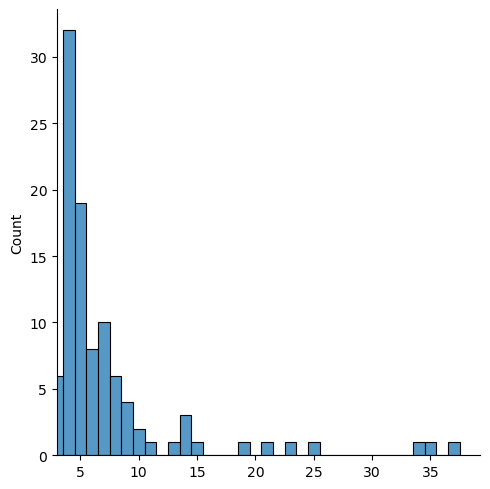

<Figure size 1000x600 with 0 Axes>

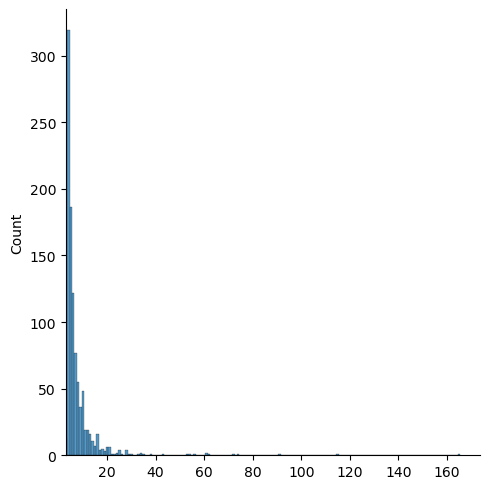

<Figure size 1000x600 with 0 Axes>

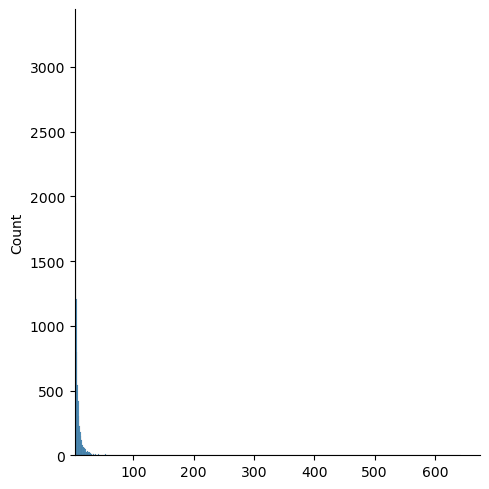

In [ ]:
# 3i

def ba_generator(N, m, plot=None):
    '''
    Implements Barabasi-Albert graph generation method, beginning with a complete
    graph of size 4
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    :param plot (string): Name of file or else will not plot figure

    returns: G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(4)

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    size = len(G.nodes())
    while size < N:
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)
        
        G.add_node(size) # named so that it doesn't overwrite itself
        for s_node in selected_nodes:
            G.add_edge(size, s_node)
            # update pool
            attachment_pool.append(size)
            attachment_pool.append(s_node)
            
        size += 1

    if plot != None:
        # plot distribution
        plt.figure(figsize=(10,6))
        degrees = [val for (node, val) in G.degree()] # list of degrees
        distplot = sns.displot(degrees, discrete=True)
        plt.xlim(min(degrees), None)
        plt.savefig(f'.\\imgs\\{plot}.png', dpi=150)

    return G

ten_two = ba_generator(pow(10, 2), 4, plot="100dist")
ten_three = ba_generator(pow(10, 3), 4, plot='1000dist')
ten_four = ba_generator(pow(10, 4), 4, plot='10000dist')

In [ ]:
# 3ii (come back later)

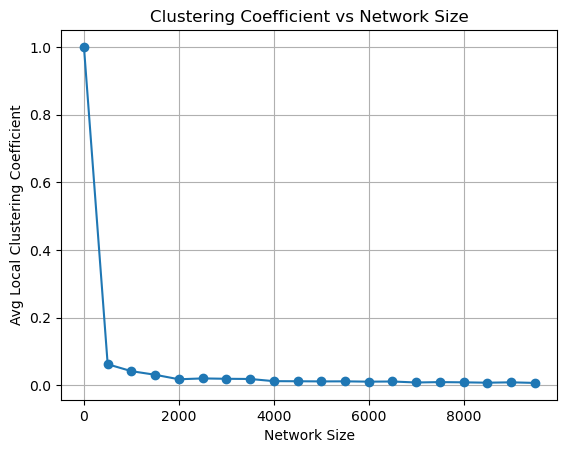

In [49]:
# 3iii

Ns = []
clustering_vals = []

for N in range(1, 10000, 500):
    G = ba_generator(N, 4)
    clustering_vals.append(nx.average_clustering(G))
    Ns.append(N)

plt.plot(Ns, clustering_vals, marker='o')
plt.xlabel('Network Size')
plt.ylabel('Avg Local Clustering Coefficient')
plt.title('Clustering Coefficient vs Network Size')
plt.grid(True)
plt.savefig(r'.\imgs\clustering_vs_size.png')
plt.show()

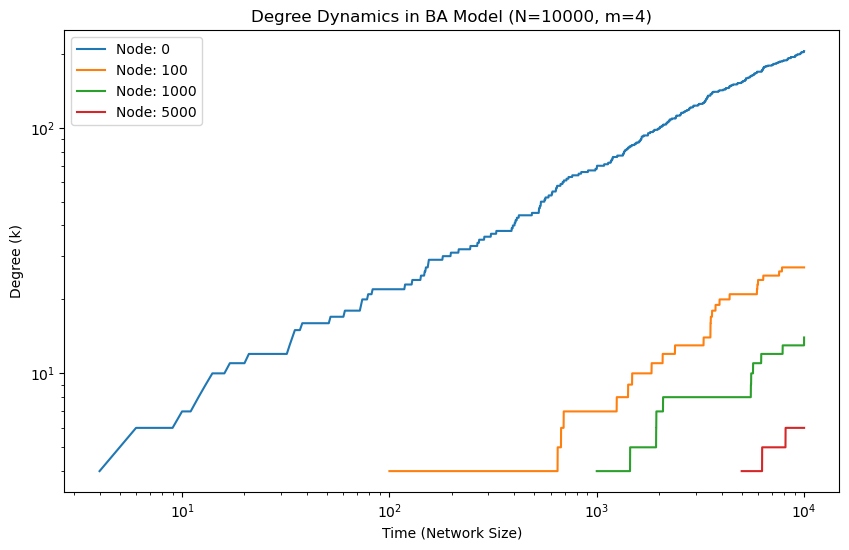

In [54]:
# 3iv

def ba_tracker(N, m):
    '''
    Implements Barabasi-Albert model for tracking the evolution of specific nodes 
    (at t=1, 100, 1000, and 5000) as graph expands
    
    :param N (int): Size of resulting network
    :param m (int): Number of new nodes to connect to at each time step
    '''
    G = nx.complete_graph(4)

    # dict of nodes to track and list of their values
    tracking_dict = {0:[], 100:[], 1000:[], 5000:[]}

    # create list of nodes and make them repeat the same number of times as their degree
    attachment_pool = []
    for node, deg in G.degree():
        attachment_pool.extend([node] * deg)

    size = len(G.nodes())
    t = 0 # init time counter

    while size < N:
        # pick m targets from pool (more entries for higher-degree nodes)
        selected_nodes = random.sample(attachment_pool, m)

        G.add_node(size)

        for s_node in selected_nodes:
            G.add_edge(size, s_node)
            # update pool
            attachment_pool.append(size)
            attachment_pool.append(s_node)

        # updating dict
        for node in tracking_dict:
            if G.has_node(node):
                tracking_dict[node].append(G.degree(node))
            else:
                tracking_dict[node].append(None) # not "born" yet
 
        size += 1
        t += 1

    # plotting
    plt.figure(figsize=(10, 6))
    
    for node, history in tracking_dict.items():
        # filter out values for nodes not yet created
        clean_history = [h for h in history if h is not None]
        # x axis is the time step where the node was active
        time_axis = range(N - len(clean_history), N)
        
        plt.plot(time_axis, clean_history, label=f'Node: {node}')

    plt.title(f"Degree Dynamics in BA Model (N={N}, m={m})")
    plt.xlabel("Time (Network Size)")
    plt.ylabel("Degree (k)")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.savefig(r'./imgs/degree_dynamics.png')

ba_tracker(10000, 4)

In [ ]:
# 3b optimization model creation

def o_model(N, delta):
    ''' 
    Implements optimization model for generating scale-free networks

    Args:
    N (int): Number of nodes in the final network. Also determines the number of timesteps
    delta (float or int): Cost-per-distance parameter

    Returns:
    G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(2) # to avoid infinite path length error

    # find minimum coordinate space that can fit all nodes by taking the ceiling of the sqrt of N
    dim = math.ceil(math.sqrt(N))

    # shuffle so i can just index into it instead of randomizing every time
    coords = [(x, y) for x in range(dim) for y in range(dim)]
    random.shuffle(coords)

    # defining first node and assigning to variable, also adding attributes
    for node in G.nodes():
        G.nodes[node]['loc'] = coords[node]

    # helper function to define cost function
    root_node = 0
    def cost(i, j):
        dist = math.dist(G.nodes[i]['loc'], G.nodes[j]['loc'])
        path_len = nx.shortest_path_length(G, source=root_node, target=j)
        return (delta * dist) + path_len
    
    size = len(G.nodes())
    while size < N:
        i = size
        G.add_node(i, loc = coords[i])
        # finding minimum of cost function
        best_j = min((j for j in G.nodes() if j != i), key=lambda j: cost(i, j))
        G.add_edge(i, best_j)
        size += 1

    return G
        
point1 = o_model(1000, .1)
ten = o_model(1000, 10)
thousand = o_model(1000, 1000)

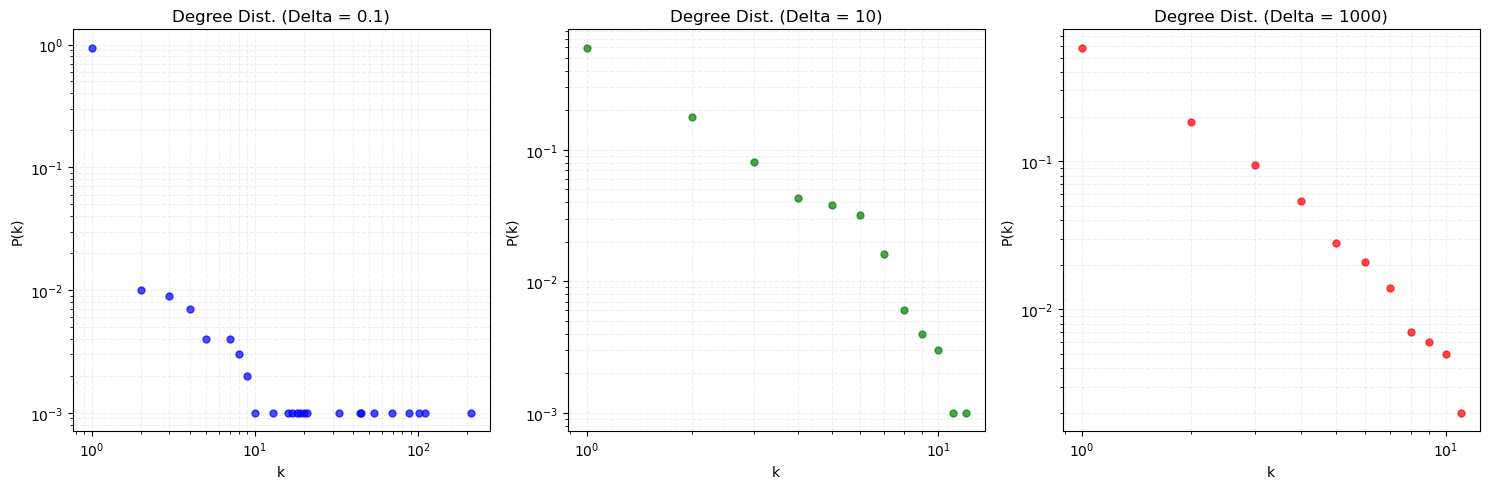

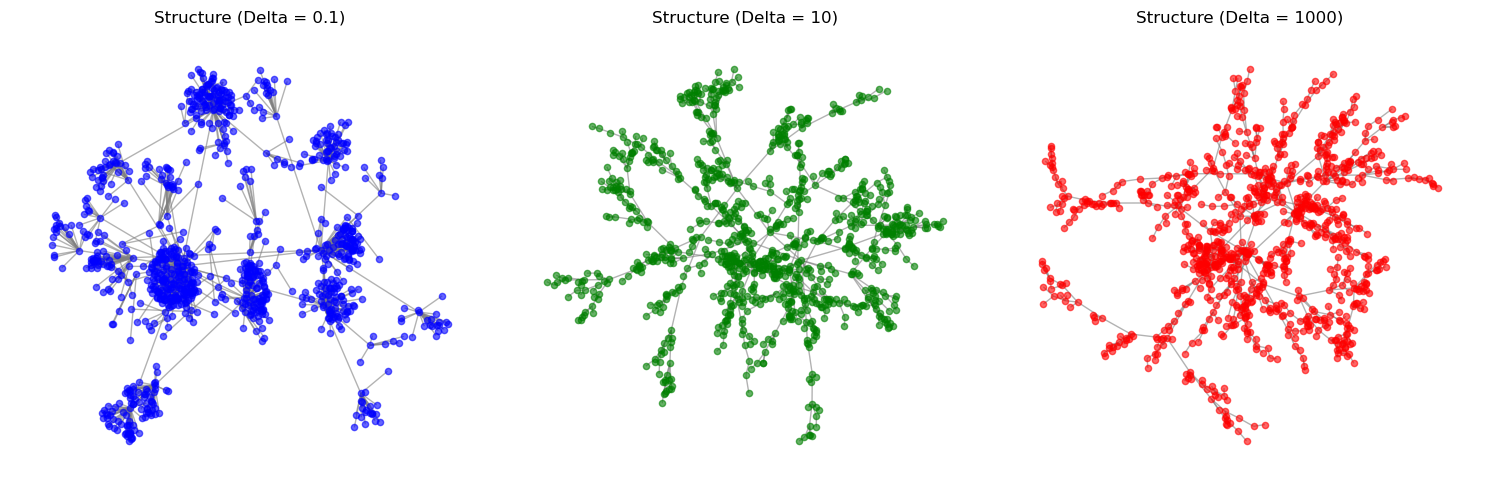

In [23]:
# 3c degree distribution plots

def plot_degree_distributions(graphs, labels):
    plt.figure(figsize=(15, 5))
    
    colors = ['blue', 'green', 'red']
    
    for i, (G, label) in enumerate(zip(graphs, labels)):
        plt.subplot(1, 3, i+1)
        
        # get degrees and calculate distribution
        degrees = [d for n, d in G.degree()]
        
        # count of each unique degree-value
        k_values, counts = np.unique(degrees, return_counts=True)
        
        # normalize counts to get P(k)
        Pk = counts / sum(counts)
        
        # log-log scale
        plt.loglog(k_values, Pk, 'o', color=colors[i], markersize=5, alpha=0.7)
        
        # formatting
        plt.title(f"Degree Dist. (Delta = {label})")
        plt.xlabel("k")
        plt.ylabel("P(k)")
        plt.grid(True, which="both", ls="--", alpha=0.2)
        
    plt.tight_layout()
    plt.savefig(r'.\imgs\o_model_degdist.png')
    plt.show()

def visualize_o_model(graphs, labels):
    plt.figure(figsize=(15, 5))

    colors = ['blue', 'green', 'red']

    for i, (G, label) in enumerate(zip(graphs, labels)):
        plt.subplot(1, 3, i+1)

        nx.draw(G, node_color=colors[i], node_size=20, edge_color='gray', alpha=0.6)
        plt.title(f"Structure (Delta = {label})")

    plt.tight_layout()
    plt.savefig(r'.\imgs\optimization_netviz.png')


graphs_list = [point1, ten, thousand]
labels_list = [0.1, 10, 1000]

plot_degree_distributions(graphs_list, labels_list)
visualize_o_model(graphs_list, labels_list)

In [25]:
# 3d link-selection and copying

def ls_model(N):
    '''
    Implements link selection model for generating scale-free networks

    Args:
        N (int): Size of resulting network as well as number of timesteps

    Returns:
        G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(2)

    size = len(G.nodes())
    while size < N:
        i = size
        G.add_node(i)
        u, v = random.choice(G.edges())
        target = random.choice(u, v)
        G.add_edge(i, target)
        size += 1
    return G    

def c_model(N, p):
    ''' 
    Implements copying model for generating scale-free networks

    Args:
        N (int): Size of resulting network as well as number of timesteps
        p (float): Probability of connecting to target directly vs one of its neighbors

    Returns:
        G (nx.Graph): Generated network
    '''
    G = nx.complete_graph(2)

    size = len(G.nodes())
    while size < N:
        i = size
        G.add_node(i)
        target = random.choice(G.nodes())
        if random.random() < p:
            G.add_edge(i, target)
        else:
            target_neighbor = random.choice(G.neighbors(target))
            G.add_edge(i, target_neighbor)
    return G

In [ ]:
# 3e pi(k) plots

def measure_pref_attachment(G, iter, m=None, delta=None, p=None):
    '''
    Measures the probability pi(k) of a new node connecting to a node of degree k 
    given network generated from one of four models -- Barabasi-Albert, Optimization,
    Link Selection, or Copying
    
    Args:
        G (nx.Graph): Generated network. Must be named according to the generation procedure (ba, o, ls, c)
        iter (int): Number of trials
        m (int, optional): "m" parameter for ba model
        delta (float or int, optional): "delta" parameter for optimization model
        p (float, optional): "p" parameter for copying model

    Returns:
        degprobs (dict): Dictionary mapping k to pi(k)
    '''
    counter = 0 # counter for trials
    observations = [] # result tracker

    if G == 'ba':
        if m == None:
            print("Error: ba model requires m parameter")
            return None
        degree_counts = Counter(d for n, d in G.degree())

        # for creation logic
        attachment_pool = []
        for node, deg in G.degree():
            attachment_pool.extend([node] * deg)

        while counter < iter:
            # copy creation logic to find node that it would have connected to
            target = random.sample(attachment_pool, m)
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # todo: create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        for k in observations:
            pi_k = ((observations.count(k)) / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    elif G == 'o':
        if delta == None:
            print("Error: optimization model requires delta parameter")
            return None
        degree_counts = Counter(d for n, d in G.degree())

        # copy helper function
        root_node = 0
        def cost(i, j):
            dist = math.dist(G.nodes[i]['loc'], G.nodes[j]['loc'])
            path_len = nx.shortest_path_length(G, source=root_node, target=j)
            return (delta * dist) + path_len
        
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            target = min((j for j in G.nodes() if j != i), key=lambda j: cost(i, j))
            # find degree and append
            k = G.degree(target)
            observations.append(k)
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        for k in observations:
            pi_k = ((observations.count(k)) / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    elif G == 'ls':
        degree_counts = Counter(d for n, d in G.degree())
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            u, v = random.choice(G.edges())
            target = random.choice(u, v)
            # find degree and append
            k = G.degree(target)
            observations.append(k)
            counter += 1
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        for k in observations:
            pi_k = ((observations.count(k)) / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    elif G == 'c':
        if p == None:
            print("Error copying model requires p parameter")
            return None
        degree_counts = Counter(d for n, d in G.degree())
        while counter < iter:
            # copy creation logic to find node that it would have connected to
            source = random.choice(G.nodes())
            if random.random() < p:
                target = source
            else:
                target = random.choice(G.neighbors(source))
            # find degree and append
            k = G.degree(target)
            observations.append(k)
        # create dict by iterating through observations and dividing the count of deg k by len(observations),
        # then dividing by degree_counts[k]
        degprobs = {}
        for k in observations:
            pi_k = ((observations.count(k)) / len(observations)) / degree_counts[k]
            degprobs[k] = pi_k
        return degprobs
    
    else:
        print('Error: G must be titled "ba", "o", "ls", or "c"')
        return None

# plotting function
def plot_pref_attachment(N=10000, m=1, delta=10, p=.5): # p not specified so going with 0.5
    plt.figure(figsize=(10, 8))

    ba = ba_generator(N, m)
    o = o_model(N, delta)
    ls = ls_model(N)
    c = c_model(N, p)

    graphs = [ba, o, ls, c]

    for G in graphs:
        degprobs = measure_pref_attachment(G, N, m, delta, p) # iter = N
        # store result for each G in dict
        results_dict = {}
        results_dict[G] = degprobs

    # plotting
    pass

plot_pref_attachment()

NameError: name 'ba_generator' is not defined

prob of k vs k (not time)

one line for the deterministic expectation and scatter for actual data

generate the network, then iterate over every degree-level and for that degree-level, 